# Задача

Потенциально изогнутая монета бросается $n$ раз и $k$ раз выпадает орел.

Ваша задача состоит в том, чтобы определить вероятность появления голов $p_h$.

Базовый случай: $k=10$, $n=14$.

__Исследуйте частотный и байесовский подходы:__
- Какова оценка $p$?
- Как изменяется результат при малых значениях $n$? При больших значениях $n$?

В случае байесовского метода, как влияет предшествование на результат?

__Бонусное задание:__ поставите ли вы на то, что следующие два броска выпадет орел?

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
from scipy.stats import beta
from plotly import express as px
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Show graphics in plotly locally
import plotly.io as pio
pio.renderers.default = 'iframe'

## Частотный подход 

Разделите число орлов на общее число бросков. Частота появления орлов является наилучшей оценкой вероятности появления орлов.
$$p_h\approx \frac{k}{n} \approx 0.714$$

Почему мы оцениваем $p_h$ именно таким образом?

На самом деле этот оценщик максимизирует вероятность данных, т.е. подгонку к данным.

### Более подробно
__получение оценки MLE__
Вероятность получения $k$ орлов и $n-k$ решек при заданном $p_h$ является биномиальным распределением:
$$p(h=k, t=n-k|p_h)={n \choose k} p_h^{k} (1-p_h)^{n-k}$$


Чтобы найти $p_h$, которое наилучшим образом соответствует наблюдениям $k=10$, $n=14$, нужно максимизировать вероятность.
$$L(p_h) = {14 \choose 10}p^{10} (1-p)^4$$ 

Поскольку нас интересует только максимум, а ${14 \choose 10}$ - константа, то ее можно опустить.
$$L(p_h) \propto p_h^{10} (1-p_h)^4$$ 

Максимизируем логарифмическое правдоподобие, так как с ним проще работать, но оно имеет тот же максимум.
$$\ln L(p_h) \propto \ln p_h^{10} + \ln(1-p_h)^4$$

Проверьте, где производная от нее равна нулю, чтобы найти точку максимума.
$$\frac{\partial \ln L(p_h)}{\partial p_h} = \frac{10}{p_h} + \frac{4}{p_h -1} = 0$$

Решив для $p_h$, получим $p_h \approx \frac{10}{14} \approx 0.714$.

### Вычислительный путь

In [3]:
def likelihood(proba, k_successes, n_trials):
    return proba**k_successes * (1-proba)**(n_trials-k_successes) 

def negative_likelihood(*args):
    return -likelihood(*args)

In [4]:
proba_range = np.arange(0.25, 1.01, 0.01)

k_successes = 10
n_trials = 14

likelihoods = likelihood(proba_range, k_successes, n_trials)

plot_df = pd.DataFrame(
    {"$p_h$":proba_range,
     "$p(data|p_h)$": likelihoods,
     },

)
px.line(plot_df, x="$p_h$", y="$p(data|p_h)$", title=f"Likelihood for {k_successes} heads and {n_trials-k_successes} tails")

In [5]:
bnds = ((1e-6, 1.0),)
res = minimize(negative_likelihood, 1/2, args=(k_successes, n_trials), bounds=bnds)
res

      fun: array([-0.00023038])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.6230248e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 20
      nit: 4
     njev: 10
   status: 0
  success: True
        x: array([0.71432129])

In [6]:
res.x[0], likelihood(res.x[0], k_successes, n_trials)

(0.7143212861838556, 0.00023038141796292375)

### Малое число наблюдейний

Предположим $k=3$, $n=3$. Три броска - три орла.

In [7]:
proba_range = np.arange(0.01, 1.01, 0.01)

k_successes = 3
n_trials = 3

likelihoods = likelihood(proba_range, k_successes, n_trials)

print(minimize(negative_likelihood, 1/2, args=(k_successes, n_trials), bounds=bnds))

plot_df = pd.DataFrame(
    {"$p_h$":proba_range,
     "$p(data|p_h)$": likelihoods,
     },

)
px.line(plot_df, x="$p_h$", y="$p(data|p_h)$", title=f"Likelihood for {k_successes} heads and {n_trials-k_successes} tails")

      fun: array([-1.])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.99999997])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([1.])


__Модель предсказывает, что монетка нечестная и всегда будет выпадать орел.__

__Бонусное задание:__ поставите ли вы на то, что следующие два броска выпадет орел?

вернемся к первой задаче: бросается $n=14$ раз и $k=10$ раз выпадает орел. $p_h \approx \frac{10}{14} \approx 0.714$, тогда вероятность двух орлов подряд $p_h^2 \approx 0.51$

In [8]:
np.round(res.x[0]**2, 2)

0.51

## Байесовский подход

Считайем, что $p_h$ - это случайная величина, которая имеет распределение, а не одно детерминированное значение.

Запишем зависимость $p_h$ от данных с помощью формулы Байеса:
$$p(p_h|data) = \frac{p(data|p_h)p(p_h)}{p(data)}$$.

Зная $p(p_h|data)$, апостериорная оценка, мы можем найти наиболее вероятное значение $p_h$ с учетом данных и наших предположений. Это и есть наша цель.

$p(data|p_h)$ - это Likelihood, с которым мы познакомились ранее.

$p(p_h)$ - это приорная оценка. Мы должны выбрать ее таким образом, чтобы она отражала наши предположения о том, каким может быть $p_h$.

$p(data)$ - нормализующая константа, которая заставляет наше распределение находиться в пределах $[0,1]$. Однако для нахождения наиболее вероятных значений она не нужна, поэтому мы можем обойтись и без нее.

Лучше всего выбрать [сопряженный prior](https://en.wikipedia.org/wiki/Conjugate_prior), так как он позволяет получить решение в замкнутой форме для $p(p_h|data)$.

Предположим, что prior имеет распределение Beta:
$$p(p_h) = Beta(p_h;a,b) = \frac{Γ(a+b)}{Γ(a)Γ(b)} p^{a-1}(1-p_h)^{b-1}∝ p^{a-1}(1-p)^{b-1}$$.

Где $Γ$ - гамма-функция, $a$ и $b$ - параметры, которые мы должны выбрать.

$\frac{Γ(a+b)}{Γ(a)Γ(b)}$ - константа, поэтому сейчас она нам не нужна.

Рассмотрим, как выглядит этот prior:


In [9]:
def p_params(a=1, b=1):
    distr = beta(a, b)
    return distr

prior_a = 1
prior_b = 1
p_h_values_range = np.arange(1e-10, 1, 0.01)


prior_distr = p_params(prior_a, prior_b)

plot_df = pd.DataFrame({
    '$p_h$': p_h_values_range,
    '$p(p_h)$': prior_distr.pdf(p_h_values_range),
})
fig = px.line(plot_df, x='$p_h$', y='$p(p_h)$', title=f'Prior pdf with parameters a={prior_a}, b={prior_b}')
fig.update_yaxes(range=[0, 1.2])

т.е в данном случае мы считаем, что все возможные вероятности выпадения орла - равновероятны, т.е мы вообще ничего не знаем об этой монетке.

Возможны и други предположения:

In [10]:
prior_a = 10
prior_b = 10
prior_distr = p_params(prior_a, prior_b)

plot_df = pd.DataFrame({
    '$p_h$': p_h_values_range,
    '$p(p_h)$': prior_distr.pdf(p_h_values_range),
})
fig = px.line(plot_df, x='$p_h$', y='$p(p_h)$', title=f'Prior pdf with parameters a={prior_a}, b={prior_b}')
fig

In [11]:
prior_a = 100
prior_b = 100
prior_distr = p_params(prior_a, prior_b)

plot_df = pd.DataFrame({
    '$p_h$': p_h_values_range,
    '$p(p_h)$': prior_distr.pdf(p_h_values_range),
})
fig = px.line(plot_df, x='$p_h$', y='$p(p_h)$', title=f'Prior pdf with parameters a={prior_a}, b={prior_b}')
fig

In [12]:
prior_a = 100
prior_b = 10
prior_distr = p_params(prior_a, prior_b)

plot_df = pd.DataFrame({
    '$p_h$': p_h_values_range,
    '$p(p_h)$': prior_distr.pdf(p_h_values_range),
})
fig = px.line(plot_df, x='$p_h$', y='$p(p_h)$', title=f'Prior pdf with parameters a={prior_a}, b={prior_b}')
fig

### Постериорная оценка

Сначала пренебрежем нормирующей константой:
$$p(p_h|data)\propto p(data|p_h)p(p_h) = p_h^{10} (1-p_h)^4 p^{a-1}(1-p)^{b-1} = p^{10+a-1} (1-p)^{4+b-1}$$

Мы получили еще одно бета-распределение, но уже без нормирующей константы. Это означает, что нормирующей константой является то, что нормирует эту константу. Это константа, обратная константе из распределения Бета:

$$\frac{1}{\beta(9+a, 3+b)} = \frac{Γ(10+a)Γ(4+b)}{Γ(10+a+4+b)}$$

Где $\beta$ - бета-функция (не путать с бета-распределением!).

Полный апостериор:
$$p(p_h|data) = \frac{Γ(10+a)Γ(4+b)}{Γ(10+a+4+b)} p^{10+a-1} (1-p)^{4+b-1}$$

Получается, что апостериор - это еще одно бета-распределение. 

Добавленные $a$ и $b$ мы можем интерпретировать как псевдосчеты "орлов" и "решек". Для $a=3$ и $b=3$ представим себе, что мы бросили монету 6 раз, получили 3 головы и 3 решки, и в результате слабо верим, что монета нечестная. 

In [13]:
def p_params_given_data(k_successes, n_trials, a=1, b=1):
    posterior_a = k_successes+a-1
    posterior_b = n_trials-k_successes+b-1
    distr = beta(posterior_a, posterior_b)
    return distr

In [14]:
prior_a = 1
prior_b = 1
k_successes = 10
n_trials = 14
posterior_distr = p_params_given_data(k_successes, n_trials, a=prior_a, b=prior_b)

plot_df = pd.DataFrame({
    '$p_h$': p_h_values_range,
    '$p(p_h|data)$': posterior_distr.pdf(p_h_values_range),
})
fig = px.line(plot_df, x='$p_h$', y='$p(p_h|data)$', title=f'Posterior pdf with prior parameters a={prior_a}, b={prior_b}')
fig

### Исследуем зависимости от исходов и приора

#### Фиксируем приор и количество выпавших решек. Изменяем количество орлов

In [15]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

prior_a = 5
prior_b = 5

num_heads_range = list(range(0, 11, 2))+[15, 30, 60, 100]

num_tails = 10

for num_heads in num_heads_range:
    posterior_distr = p_params_given_data(num_heads, num_heads+num_tails, a=prior_a, b=prior_b)

    fig.add_trace(
        go.Scatter(x=p_h_values_range, y=posterior_distr.pdf(p_h_values_range),
                    mode='lines',
                    visible=False)
        
    )


# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        label=f"{num_heads_range[i]} орлы",
        args=[{"visible": [False] * len(fig.data)},
              {"title": f"Количество: орлов: {num_heads_range[i]}, решек: {num_tails}\nPrior a(орлы)={prior_a}, b(решки)={prior_b}"},
              ],
    )
    step["args"][0]["visible"][i] = True  
    steps.append(step)

active_idx = 5
sliders = [dict(
    active=active_idx,
    pad={"t": 50},
    steps=steps,
)]

fig.data[active_idx].visible = True

fig.update_layout(
    sliders=sliders
)

fig.update_layout(xaxis_range=[0,1],
                  xaxis = dict(
                    tickmode = 'linear',
                    tick0 = 0,
                    dtick = 0.05
                  ),
                  yaxis_range=[0,15],
                  title=f"Количество: орлов: {num_heads_range[active_idx]}, решек: {num_tails}\nPrior a(орлы)={prior_a} b(решки)={prior_b}")


fig.show()

#### Фиксируем количество орлов и решек и варьируем параметр a приора

In [16]:
fig = go.Figure()

prior_b = 4

prior_a_range = list(range(0, 11, 2))+[15, 30, 60, 100]

num_tails = 7
num_heads = 14

for prior_a in prior_a_range:
    posterior_distr = p_params_given_data(num_heads, num_heads+num_tails, a=prior_a, b=prior_b)
    fig.add_trace(
        go.Scatter(x=p_h_values_range, y=posterior_distr.pdf(p_h_values_range),
                    mode='lines',
                    visible=False)
        
    )


# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        label=f"prior a {prior_a_range[i]}",
        args=[{"visible": [False] * len(fig.data)},
              {"title": f"Количество: орлов: {num_heads}, решек: {num_tails}\nPrior a(орлы)={prior_a_range[i]}, b(решки)={prior_b}"},
              ],
    )
    step["args"][0]["visible"][i] = True  
    steps.append(step)

active_idx = 5
sliders = [dict(
    active=active_idx,
    pad={"t": 50},
    steps=steps,
)]

fig.data[active_idx].visible = True

fig.update_layout(
    sliders=sliders
)

fig.update_layout(xaxis_range=[0,1],
                  xaxis = dict(
                    tickmode = 'linear',
                    tick0 = 0,
                    dtick = 0.05
                  ),
                  yaxis_range=[0, 15],
                  title=f"Количество: орлов: {num_heads}, решек: {num_tails}\nPrior a(орлы)={prior_a_range[active_idx]}, b(решки)={prior_b}")


fig.show()

# Какова вероятность выпасть двум орлам?

Все зависит от вашего приора - т.е от вашего опыта и предположения о вопросе

Интегрируем по всем возможным значениям $p_h$ и суммируем вероятности наблюдения двух орлов. При этом учитывается не только наиболее вероятное значение $p_h$, но и вероятность увидеть два орла при всех возможных значениях $p_h$, 

По сути, он делает прогнозы по многим гипотезам и суммирует их, взвешивая по степени обоснованности гипотез.

$$P(HH|data)= \int_{0}^{1} P(HH|p_h)⋅P(p_h|data)\ \\partial p_h$$

Мы знаем, что броски монет независимы, поэтому:
$$P(HH|p_h) == p_h^2$$.

$$P(HH|data)= \int_{0}^{1} p_h^2⋅P(p_h|data)\ \partial p_h$$

Подставляя апостериор, получаем:

$$p(p_h|data) = \frac{Γ(k+a)Γ((n-k)+b)}{Γ(k+a+(n-k)+b)} p^{k+a-1} (1-p)^{(n-k)+b-1}$$



$$P(HH|data)= \frac{Γ(k+a)Γ((n-k)+b)}{Γ(k+a+(n-k)+b)} \int_{0}^{1} p_h^2 ⋅ p^{k+a-1} (1-p)^{(n-k)+b-1} \ \\partial p_h$$

Решая интеграл, получаем:


$$P(HH|data)= \frac{Γ(k+a)Γ((n-k)+b)}{Γ(k+a+(n-k)+b)} \cdot \frac{Γ(k+a+2+(n-k)+b)}{Γ(k+a+2)Γ((n-k)+b)} = \frac{\beta(k+a+2,(n-k)+b)}{\beta(k+a,(n-k)+b)}$$



In [17]:
from scipy.special import beta as beta_func
def predict_proba(
    predicted_heads,
    k_heads,
    n_trials,
    prior_a,
    prior_b,
    ):
    return beta_func(k_heads+prior_a+2,n_trials-k_heads+prior_b)/beta_func(k_heads+prior_a, n_trials-k_heads+prior_b)

In [18]:
num_head = 2
total_head = 10
total_toss = 14
prior_a = 1
prior_b = 1
predict_proba(num_head, total_head, total_toss, prior_a, prior_b)

0.4852941176470588

In [19]:
num_head = 2
total_head = 10
total_toss = 14
prior_a = 100
prior_b = 100
predict_proba(num_head, total_head, total_toss, prior_a, prior_b)

0.2653770919364518

# Смещение уверенности

In [20]:
import scipy.stats as st

/Users/stureiko/Library/Application Support/pypoetry/venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning:

overflow encountered in _beta_ppf



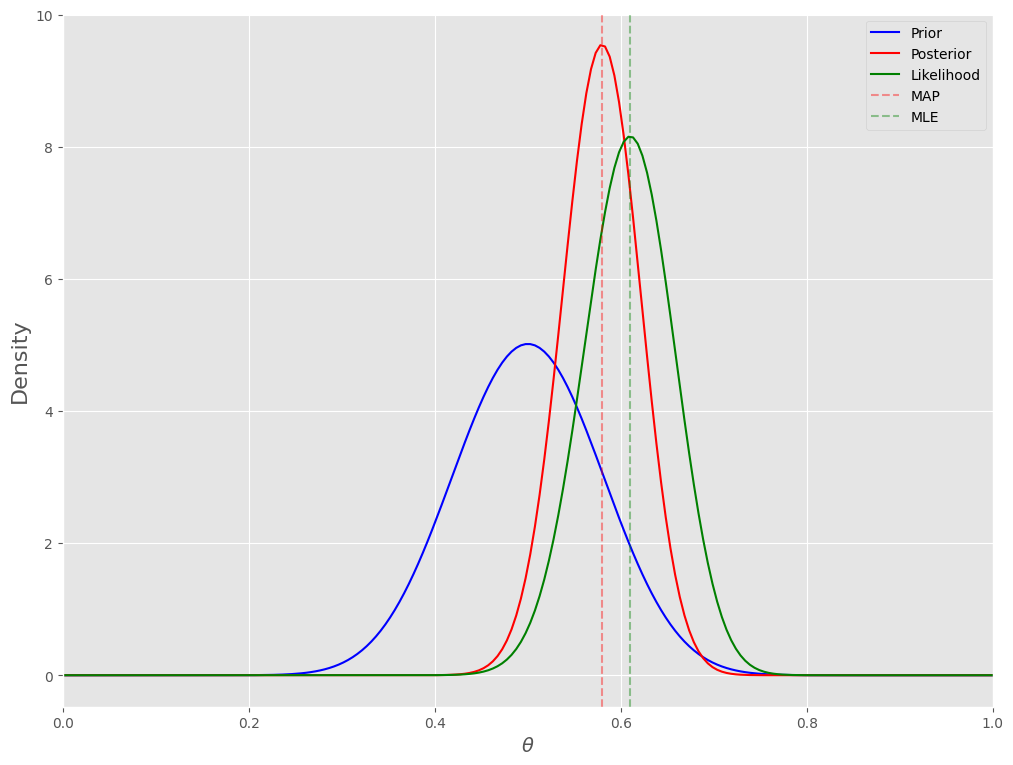

In [34]:
n = 100
h = 61
p = h/n
rv = st.binom(n, p)
mu = rv.mean()

a, b = 20, 20
prior = st.beta(a, b)
post = st.beta(h+a, n-h+b)
ci = post.interval(0.95)

thetas = np.linspace(1e-5, 1, 200)
plt.figure(figsize=(12, 9))
plt.style.use('ggplot')
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();